# Time Augumentation

- [LSTM Autoencoder for Extreme Rare Event Classification in Keras](https://towardsdatascience.com/lstm-autoencoder-for-extreme-rare-event-classification-in-keras-ce209a224cfb)

tf version 2.3.1
df.shape (56021, 31)
data_sampling_period = 33.763769
data_sampling_rate = 29.617546548194902
df_data_sampling_period 33.763769 RESAMPLE_PEDIOD 200
len(rep_stretches) 504
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0}
X_train.shape (76074, 9) y_train.shape (76074, 9)
X_train.mean(axis=0) [-2.45262469e-05  1.69879704e-02  1.71748331e-03 -2.12316715e-04
 -1.60348269e-03  4.33154653e-03  5.56280917e-04  2.91999528e-03
  2.53564398e-03]
X_all.shape (9458, 9) y_all.shape (9458, 9)
[-0.25819568 -0.30453781 -0.48337002 -0.23060827 -0.47773488 -0.45891124
 -0.30517686 -0.60728454 -0.78835038]
X_ts_all.shape (9359, 100, 9) y_ts_all (9359, 100, 9)
X_ts_train.shape (75975, 100, 9) True


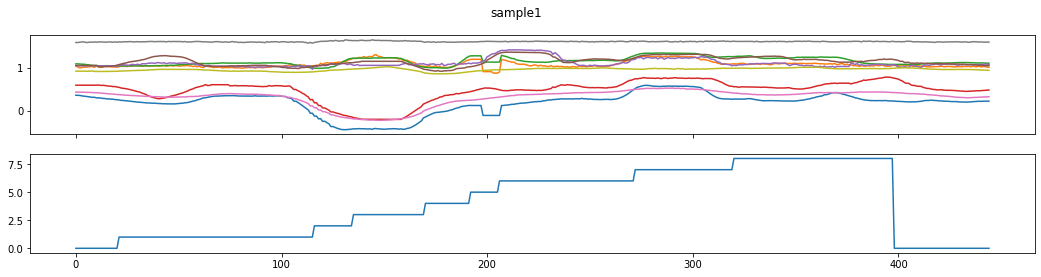

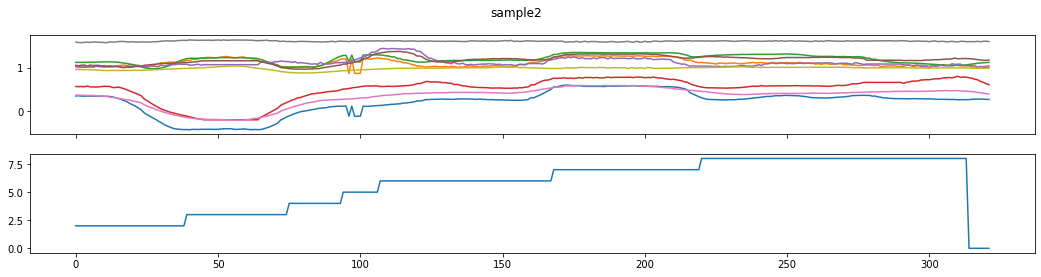

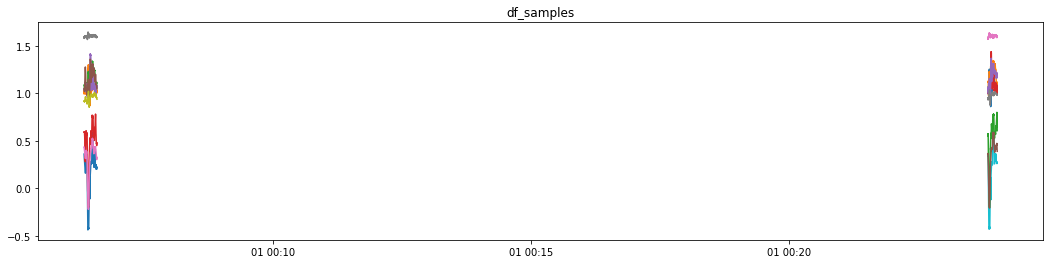

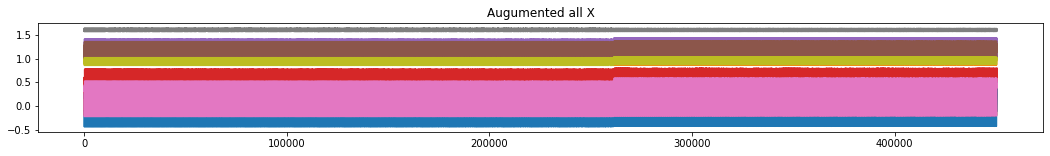

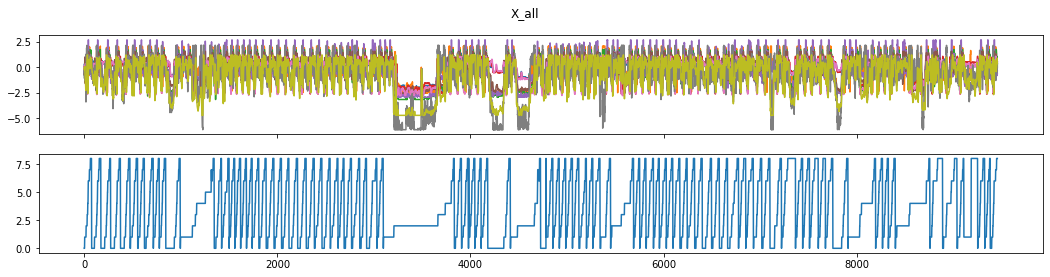

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# pd.options.plotting.backend = "plotly"

from datetime import datetime, timedelta
from pathlib import Path

import tensorflow as tf
print("tf version", tf.__version__)

from tsa_aug import *

# DataFrame 

# DATA_PATH = Path("../DATA/denso/20200601/2020-05-07_124628_r4.csv")
DATA_PATH = Path("./2020-05-07_124628_r4.csv")

def read_data(path):
    df = pd.read_csv(str(path))
    df["Time"] = pd.to_datetime( datetime(2020,1,1,0,0) + pd.to_timedelta(df["Time"], unit="s") )
    df.set_index("Time", inplace=True)
    return df

def select_data(df):
    df_data = df.filter(regex="^Option0(0|1|2)_(x|y|z)$").copy()
    return df_data

def select_target(df):
    df_targets = df[["element_work"]].copy()
    return df_targets

def select_df_by_range(df, start_time, end_time):
    return df[start_time:end_time]

def draw_graph(xs, ys=None, figsize=None, title=None):
    if ys is None:
        if figsize is None:
            figsize=(18,2)
        plt.figure(figsize=figsize);
        if type(xs) is pd.DataFrame:
            xs = xs.values
        plt.plot(xs);
        if title:
            plt.title(title);
    else:
        if figsize is None:
            figsize=(18,4)
        fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=figsize)
        if title:
            fig.suptitle(title)
        if type(xs) is pd.DataFrame:
            xs = xs.values
        if type(ys) is pd.DataFrame:
            ys = ys.values
        ax1.plot(xs)
        ax2.plot(ys)

def set_random_seed(seed=43):
    seed = 123
    import tensorflow as tf
    import random
    import os
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHseed"] = str(seed)

df = read_data(DATA_PATH)
print("df.shape", df.shape)

df_data = select_data(df)
df_targets = select_target(df)
data_column_names = list(df_data.columns)

## sampling rate

df_data.index.to_series().diff().mean()

# 1コマの時間(ms)
data_sampling_period = df_data.index.to_series().diff().mean().value/1e6
print(f"data_sampling_period = {data_sampling_period}")

# fps
data_sampling_rate = 1e9/df_data.index.to_series().diff().mean().value
print(f"data_sampling_rate = {data_sampling_rate}")

RESAMPLE_PEDIOD = 200
print("df_data_sampling_period", data_sampling_period, "RESAMPLE_PEDIOD", RESAMPLE_PEDIOD)

# 1周期分の時系列データのサンプリング

## candidate #1

# START_TIME = "2020-01-01 00:05:12 5000"
CYCLE_START_TIME1 = datetime(2020, 1, 1, 0, 6, 20, 0)
# END_TIME = "2020-01-01 00:05:30"
CYCLE_END_TIME1 = datetime(2020, 1, 1, 0, 6, 35, 0)


df_data_sample1 = select_df_by_range(df_data, CYCLE_START_TIME1, CYCLE_END_TIME1)
df_targets_sample1 = select_df_by_range(df_targets, CYCLE_START_TIME1, CYCLE_END_TIME1)
# print("df_data_sample1.shape", df_data_sample1.shape, "df_target_sample1.shape", df_targets_sample1.shape)
draw_graph(df_data_sample1, df_targets_sample1, title="sample1")

## candidate #2

# CYCLE_START_TIME2 = datetime(2020, 1, 1, 0, 23, 40, 0)
CYCLE_START_TIME2 = datetime(2020, 1, 1, 0, 23, 51, 0)
# END_TIME = "2020-01-01 00:05:30"
CYCLE_END_TIME2 = datetime(2020, 1, 1, 0, 24, 1, 950000)


df_data_sample2 = select_df_by_range(df_data, CYCLE_START_TIME2, CYCLE_END_TIME2)
df_targets_sample2 = select_df_by_range(df_targets, CYCLE_START_TIME2, CYCLE_END_TIME2)
# print(df_targets.value_counts())
# print(df_data_sample2.shape, df_targets_sample2.shape)
draw_graph(df_data_sample2, df_targets_sample2, title="sample2")

## candidate #3

CYCLE_START_TIME3 = datetime(2020, 1, 1, 0, 17, 30, 600000)
# END_TIME = "2020-01-01 00:05:30"
CYCLE_END_TIME3 = datetime(2020, 1, 1, 0, 17, 46, 500000)


df_data_sample3 = select_df_by_range(df_data, CYCLE_START_TIME3, CYCLE_END_TIME3)
df_targets_sample3 = select_df_by_range(df_targets, CYCLE_START_TIME3, CYCLE_END_TIME3)
# print(df_data_sample3.shape, df_targets_sample3.shape)
# draw_graph(df_data_sample3, df_targets_sample3)

## candidate #4

CYCLE_START_TIME4 = datetime(2020, 1, 1, 0, 10, 18, 650000)
# END_TIME = "2020-01-01 00:05:30"
CYCLE_END_TIME4 = datetime(2020, 1, 1, 0, 12, 47, 500000)


df_data_sample4 = select_df_by_range(df_data, CYCLE_START_TIME4, CYCLE_END_TIME4)
df_targets_sample4 = select_df_by_range(df_targets, CYCLE_START_TIME4, CYCLE_END_TIME4)
# print(df_data_sample4.shape, df_targets_sample4.shape)
# draw_graph(df_data_sample4, df_targets_sample4)

plt.figure(figsize=(18,4))
plt.title("df_samples")
plt.plot(df_data_sample1)
plt.plot(df_data_sample2);
# plt.plot(df_data_sample3);
# plt.plot(df_data_sample4);

# Data Augument

RANDOM_SEED = 101
set_random_seed(RANDOM_SEED)

## repeat transform

def transform_n_times_Xy(xs, ys, fx, fy, params):
    xss, yss = [], []
    for param in loops:
        xs_new = fx(xs, param)
        ys_new = fy(ys, param)
        xss.append(xs_new)
        yss.append(ys_new)
    return np.concatenate(xss, axis=0), np.concatenate(yss, axis=0)

def stretches_n_times_Xy(xs, ys, loops):
    xss, yss = [], []
    for i in loops:
        xs_new = time_stretch(xs, i)
        ys_new = time_stretch(ys, i, kind="nearest")
        xss.append(xs_new)
        yss.append(ys_new)
    return np.concatenate(xss, axis=0), np.concatenate(yss, axis=0)

def partial_stretches_n_times_Xy(xs, ys, rep_stretches):
    xss, yss = [], []
    for stretches in rep_stretches:
#         print(stretches)
        xs_new = partial_time_stretch(xs, stretches)
        ys_new = partial_time_stretch(ys, stretches, kind="nearest")
        xss.append(xs_new)
        yss.append(ys_new)
    return np.concatenate(xss, axis=0), np.concatenate(yss, axis=0)

def time_warps_n_times_Xy(xs, ys, n_times, n_knots=500):
    xss, yss = [], []
    for _ in range(n_times):
        xs_new, ys_new = time_warp_Xy(xs, ys, n_knots=n_knots)
        xss.append(xs_new)
        yss.append(ys_new)
    return np.concatenate(xss, axis=0), np.concatenate(yss, axis=0)

def merge_data(xss):
    return np.concatenate(xss, axis=0)

rep_stretches = []
for s in np.arange(1, 3.1, 0.1):
    for d in np.arange(0.1, 0.5, 0.1):
        for x in np.arange(0, 1.1, d):
            rep_stretches.append([[x, x+d, s]])

print("len(rep_stretches)", len(rep_stretches))

X1_, y1_ = partial_stretches_n_times_Xy(df_data_sample1.values, df_targets_sample1.values, rep_stretches=rep_stretches)
X2_, y2_ = partial_stretches_n_times_Xy(df_data_sample2.values, df_targets_sample2.values, rep_stretches=rep_stretches)
X3_, y3_ = partial_stretches_n_times_Xy(df_data_sample2.values, df_targets_sample2.values, rep_stretches=rep_stretches)

# print(X1_.shape, y1_.shape, X2_.shape, y2_.shape, X3_.shape, y3_.shape)


X1, y1 = time_warps_n_times_Xy(X1_, y1_, n_times=10)
X2, y2 = time_warps_n_times_Xy(X2_, y2_, n_times=10)
# X3, y3 = time_warps_n_times_Xy(X3_, y3_, n_times=10)

X_ = merge_data([X1_, X2_])
y_ = merge_data([y1_, y2_])
 
X_stretched = jitter(X_, sigma=0.005)
y_stretched = y_

draw_graph(X_, title="Augumented all X")

print(set(y_stretched.flatten().tolist()))

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


def resample_data(xs):
    return resampling(xs, src_period=data_sampling_period, dst_period=RESAMPLE_PEDIOD, kind="linear")

def resample_targets(xs):
    return resampling(xs, src_period=data_sampling_period, dst_period=RESAMPLE_PEDIOD, kind="nearest")

def preprocess(xs, pipes):
    for p in pipes:
        xs = p(xs.copy())
    return xs

def clipping_data(xs):
    MIN_PERC, MAX_PERC = 2.5, 97.5
    c_min, c_max = np.percentile(xs, [MIN_PERC, MAX_PERC], axis=0)
    return np.clip(xs, c_min, c_max)

# TODO
sc = StandardScaler()
sc.fit(X_stretched)
def scaling_data(xs):
    global sc
    return sc.transform(xs)

ohe = OneHotEncoder(sparse=False)
ohe.fit(y_stretched)
def ohe_targets(xs):
    xs = xs.reshape(-1, 1)
    return ohe.transform(xs).astype(dtype="int32")

## Training Data

X_train = preprocess(X_stretched, [resample_data, clipping_data, scaling_data])
y_train = preprocess(y_stretched, [resample_targets, ohe_targets])

print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_train.mean(axis=0)", X_train.mean(axis=0))

X_sample1 = preprocess(df_data_sample1.values, [resample_data, clipping_data, scaling_data])
X_sample2 = preprocess(df_data_sample2.values, [resample_data, clipping_data, scaling_data])




## ~~Validation Data~~ All data

# ohe_targets(resample_targets(df_targets_valid.values))

# VALID_START_TIME = datetime(2020, 1, 1, 0, 27, 0)
VALID_START_TIME = datetime(2020, 1, 1, 0, 15, 0)
VALID_END_TIME =   datetime(2020, 1, 1, 0, 38, 0)

df_data_all = (read_data(DATA_PATH)
     .pipe(select_data)
#      .pipe(select_df_by_range, VALID_START_TIME, VALID_END_TIME) # all
    )#.iloc[:1000]
df_target_all = (read_data(DATA_PATH)
     .pipe(select_target)
#      .pipe(select_df_by_range, VALID_START_TIME, VALID_END_TIME) # all
    )#.iloc[:1000]
# print(df_data_all.shape, df_target_all.shape)

X_all = preprocess(df_data_all.values, [resample_data, clipping_data, scaling_data])
y_all = preprocess(df_target_all.values, [resample_targets, ohe_targets])
print("X_all.shape", X_all.shape, "y_all.shape", y_all.shape)
print(X_all.mean(axis=0))

draw_graph(X_all, y_all.argmax(axis=1), title="X_all")

# temporalize

T, D = 100, 9

def temporalize(xs, ys, length):
    assert type(xs)==np.ndarray and xs.ndim==2
    assert type(ys)==np.ndarray and ys.ndim==2
    assert len(xs)==len(ys)
    assert type(length)==int
    
    out_x, out_y = [], []
    for i in range(len(xs)-length+1):
        out_x.append(xs[i:i+length, :])
        out_y.append(ys[i:i+length, :])
    return np.array(out_x), np.array(out_y)
    

X_ts_train, Y_ts_train = temporalize(X_train, X_train, T)
X_ts_all, y_ts_all = temporalize(X_all, y_all, T)

print("X_ts_all.shape", X_ts_all.shape, "y_ts_all", y_ts_all.shape)
print("X_ts_train.shape", X_ts_train.shape, np.allclose(X_ts_train, Y_ts_train))

# Autoencoder

# VAE

In [2]:
from tensorflow.keras.layers import Dense, SimpleRNN, Input, LSTM, Flatten, Bidirectional, Dropout, GRU
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Lambda, Layer
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_squared_error

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


T, D = 100, 9
BATCH_SIZE = 1024
INTERMEDIATE_DIM = 100
LATENT_DIM = 100
EPSILON_STD=1.0

class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 


# LSTM encoding
x = Input(shape=(T, D,))
h = LSTM(INTERMEDIATE_DIM, activation="tanh", use_bias=True, name="lstm_e1", 
    return_sequences=False,
    recurrent_activation='sigmoid',
    kernel_initializer='glorot_normal',
    dropout = 0.5,
    recurrent_initializer='orthogonal')(x)
# VAE Z layer
z_mean = Dense(LATENT_DIM)(h)
z_log_sigma = Dense(LATENT_DIM)(h)

z = Sampling()([z_mean, z_log_sigma])

# decoded LSTM layer
decoder_h = LSTM(INTERMEDIATE_DIM, return_sequences=True)
decoder_mean = LSTM(D, activation="tanh", use_bias=True, name="lstm_d1", 
    return_sequences=True,
    recurrent_activation='sigmoid',
    kernel_initializer='glorot_normal',
    dropout = 0.5,
    recurrent_initializer='orthogonal')
h_decoded = RepeatVector(T)(z)
h_decoded = decoder_h(h_decoded)
# decoded layer
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)
# encoder, from inputs to latent space
encoder = Model(x, z_mean)
# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(LATENT_DIM,))
_h_decoded = RepeatVector(T)(decoder_input)
_h_decoded = decoder_h(_h_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
vae.add_loss(kl_loss)

# vae.compile(optimizer='rmsprop', loss=vae_loss)

In [3]:
vae.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])

In [4]:
encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 9)]          0         
_________________________________________________________________
lstm_e1 (LSTM)               (None, 100)               44000     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
Total params: 54,100
Trainable params: 54,100
Non-trainable params: 0
_________________________________________________________________


In [5]:
generator.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 100)          80400     
_________________________________________________________________
lstm_d1 (LSTM)               (None, 100, 9)            3960      
Total params: 84,360
Trainable params: 84,360
Non-trainable params: 0
_________________________________________________________________


```
set_random_seed(RANDOM_SEED)

es = EarlyStopping(patience=10, verbose=2, monitor="mse")
# cp = ModelCheckpoint(filepath="saved_model_vae_01/", monitor="mse", save_best_only=True, verbose=1)
# r = vae.fit(X_ts_train, Y_ts_train, epochs=200, batch_size=BATCH_SIZE, callbacks=[es, cp], verbose=2)
r = vae.fit(X_ts_train, Y_ts_train, epochs=200, batch_size=BATCH_SIZE, callbacks=[es], verbose=2)
```

```
vae.save("saved_model_vae_01/", )
encoder.save("saved_model_enc_01/")
generator.save("saved_model_gen_01")
```

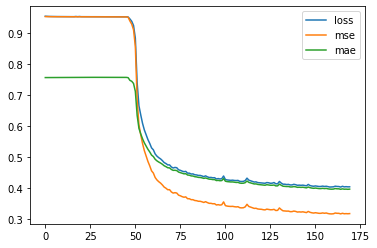

In [6]:
# hist = pd.DataFrame(r.history)
# hist.to_csv("vae_01.csv")
hist = pd.read_csv("vae_01.csv", index_col=0)
hist.plot();

# Evaluate

75/75 [==============================] - 2s 21ms/step - loss: 0.4084 - mean_squared_error: 0.3209 - mean_absolute_error: 0.3973


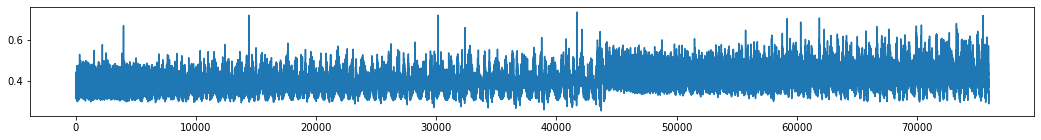

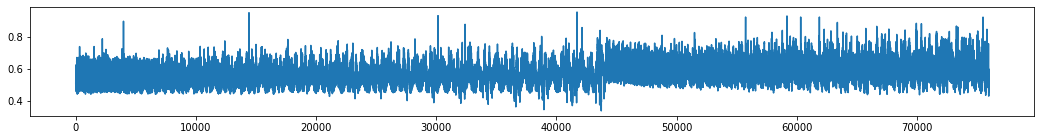

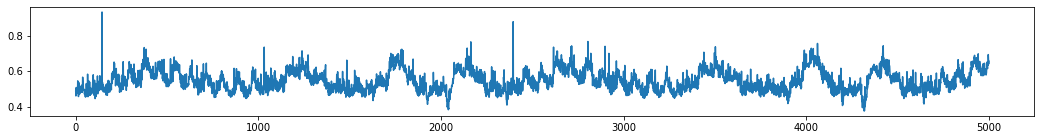

In [7]:
from tensorflow.keras.models import load_model

vae = load_model("saved_model_vae_01/")
generator = load_model("saved_model_gen_01/")
encoder = load_model("saved_model_enc_01/")

BATCH_SIZE = 1024

vae.evaluate(X_ts_train, Y_ts_train, batch_size=BATCH_SIZE)

# Get train MAE loss.
X_ts_pred = vae.predict(X_ts_train)
# train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)1111111\^-a

mae_loss = np.abs(X_ts_train - X_ts_pred).mean(axis=1).mean(axis=1)
mae_loss.shape
draw_graph(mae_loss)

rmse_loss = np.sqrt(np.square(X_ts_train - X_ts_pred).mean(axis=1).mean(axis=1))
rmse_loss.shape
draw_graph(rmse_loss)

draw_graph(rmse_loss[30000:35000])

# predict all data

X_pred[:,0,:].shape (9359, 9) X_ts_all[:,0,:].shape (9359, 9)
rmse.shape (9359,)
rmse2.shape (9359,)


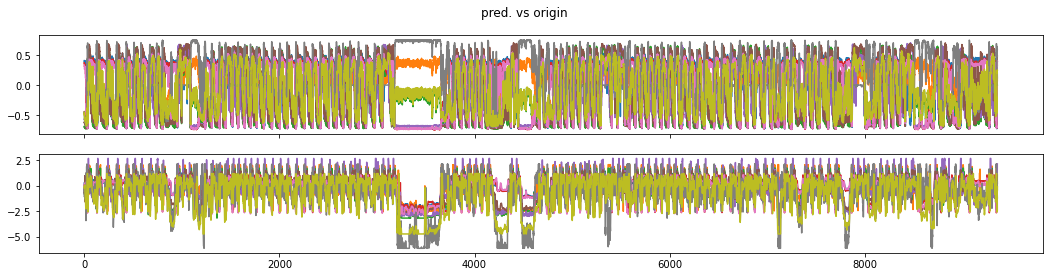

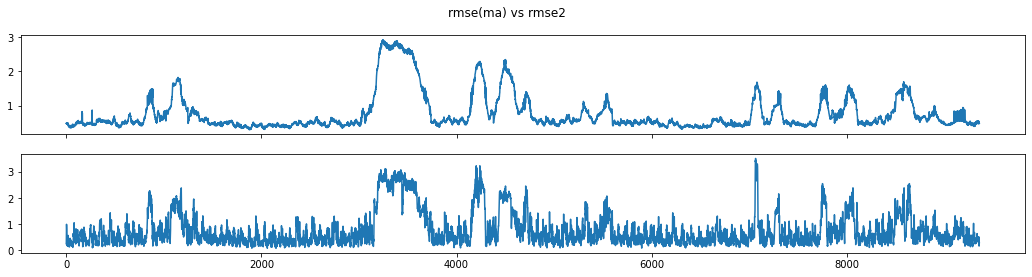

In [8]:
from tensorflow.keras.models import load_model

# ae = load_model("saved_model_ae_01/")
X_pred = vae.predict(X_ts_all)

draw_graph(X_pred[:,0,:], X_ts_all[:,0,:], title="pred. vs origin")
print("X_pred[:,0,:].shape", X_pred[:,0,:].shape, "X_ts_all[:,0,:].shape", X_ts_all[:,0,:].shape)

rmse = np.sqrt(np.square(X_pred-X_ts_all)).mean(axis=(1,2))
print("rmse.shape", rmse.shape)


rmse2 = np.sqrt(np.square(X_pred-X_ts_all))[:,50,:].mean(axis=1)
print("rmse2.shape", rmse2.shape)
draw_graph(rmse, rmse2, title="rmse(ma) vs rmse2")


# 全体で予測

(9458, 9) (9458, 9)
(9458, 9) (9458, 9)


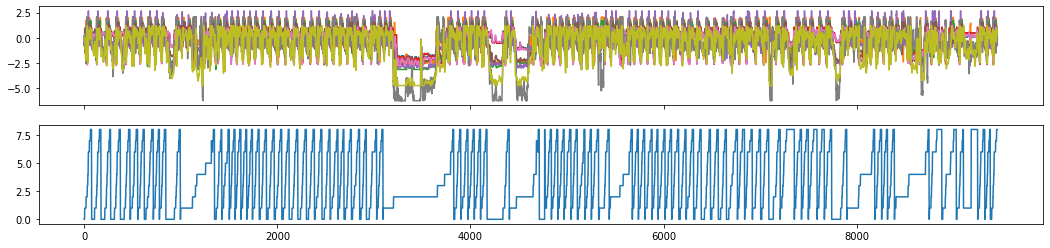

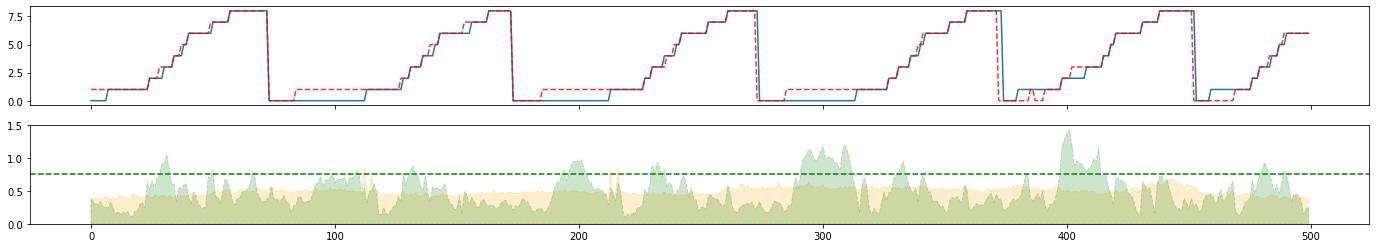

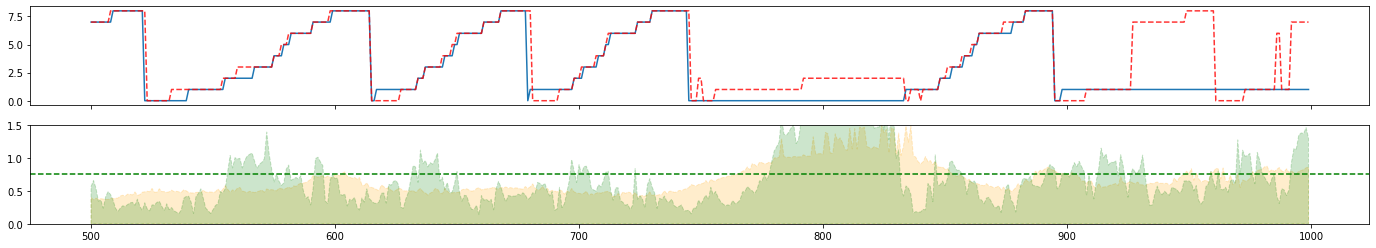

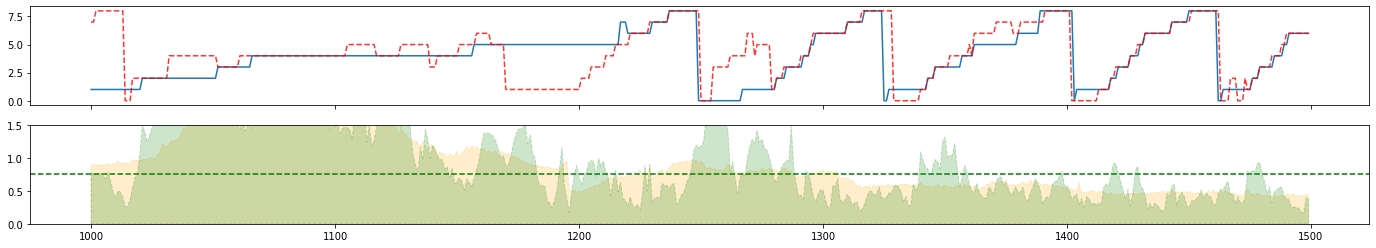

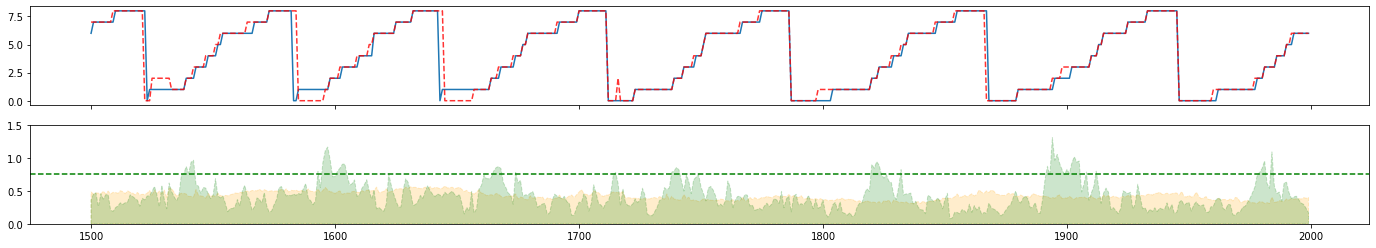

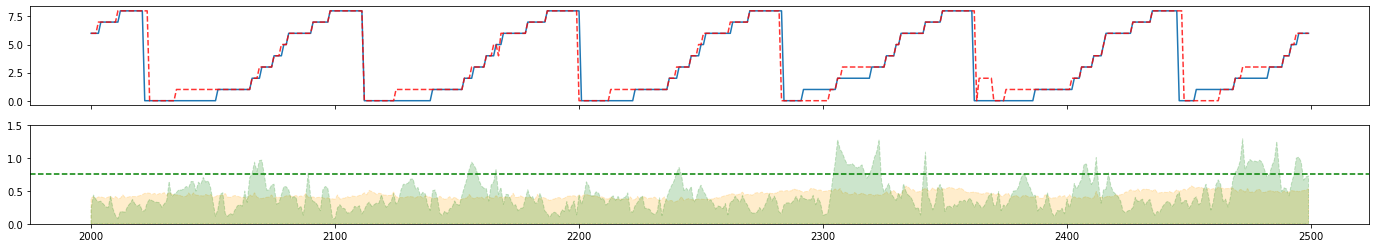

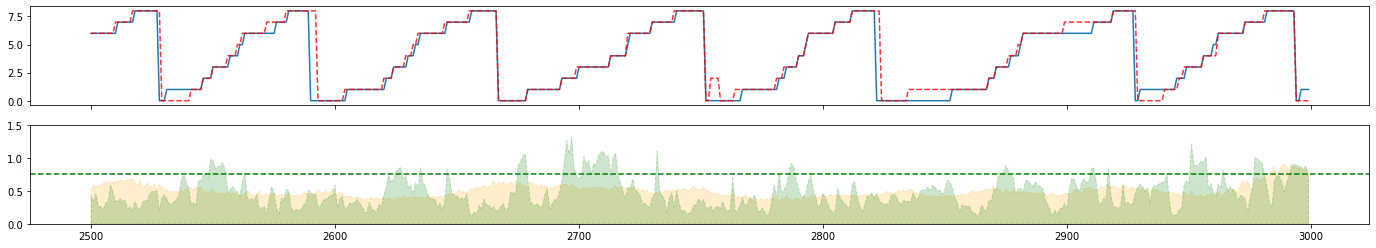

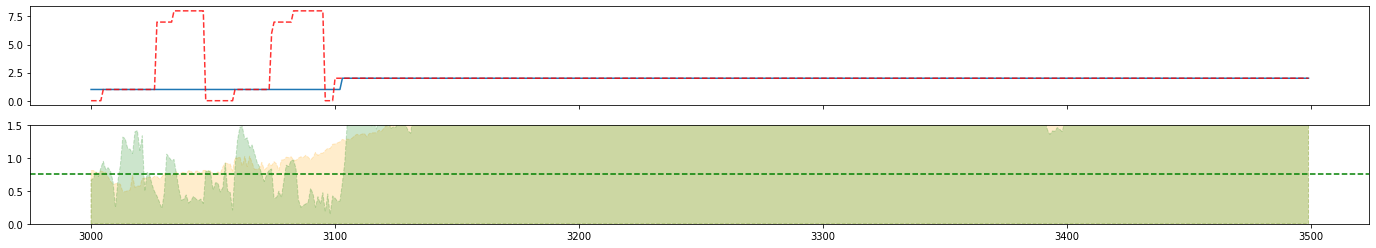

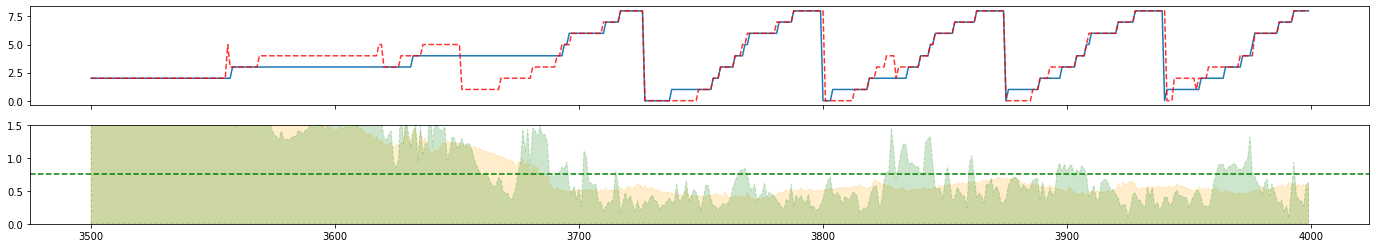

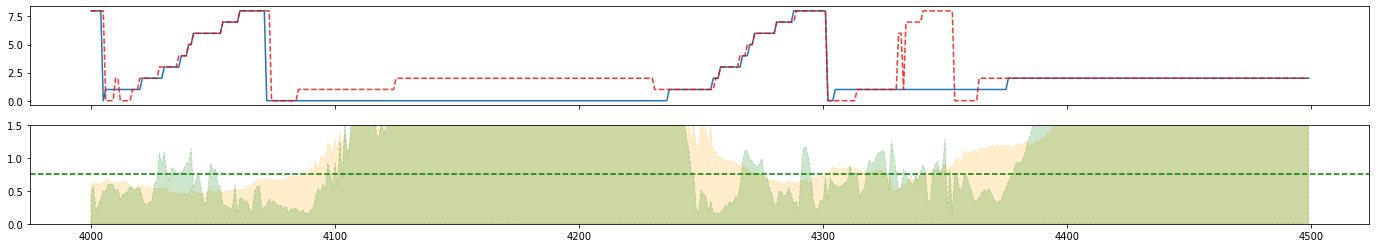

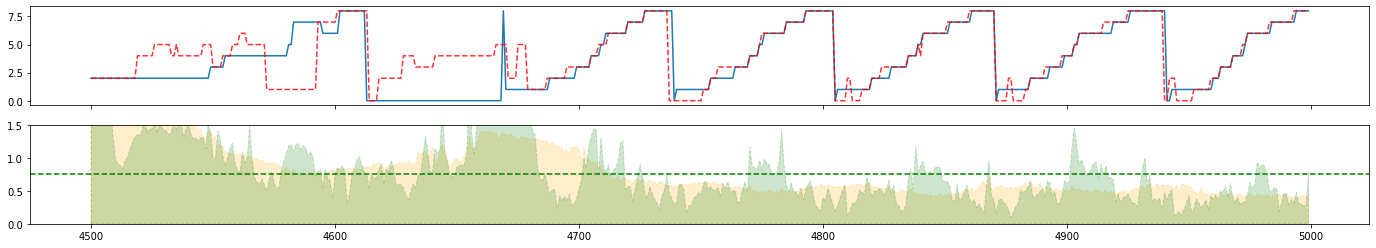

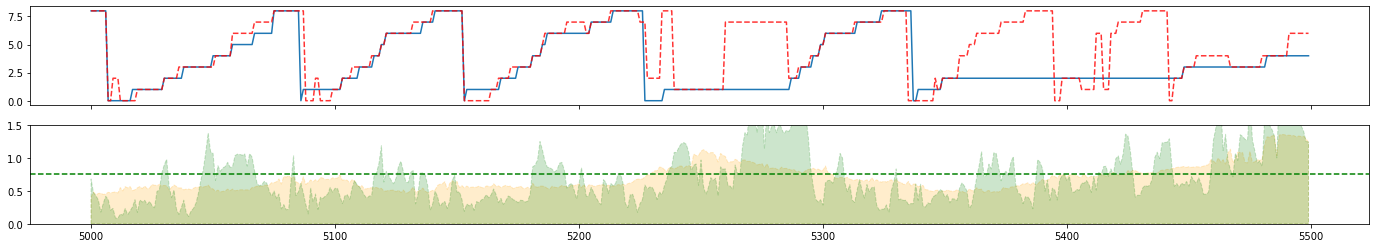

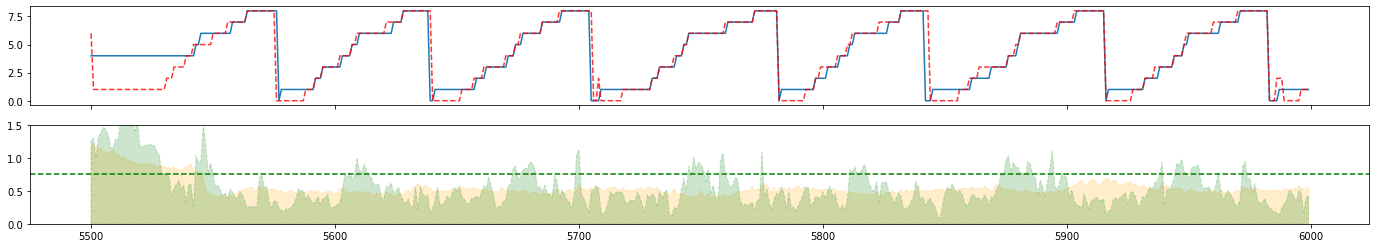

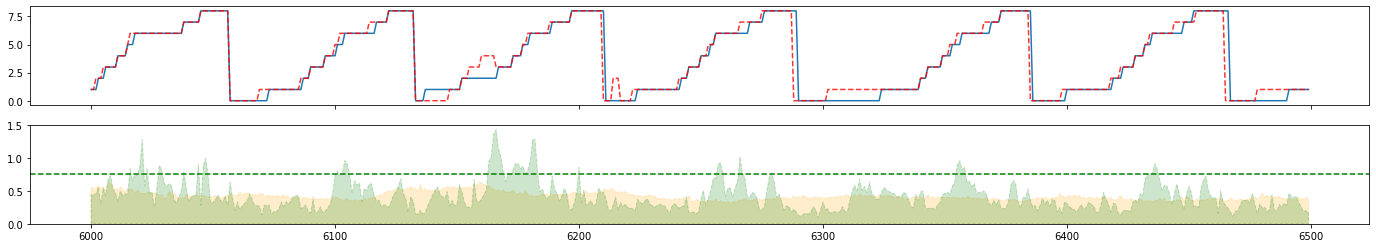

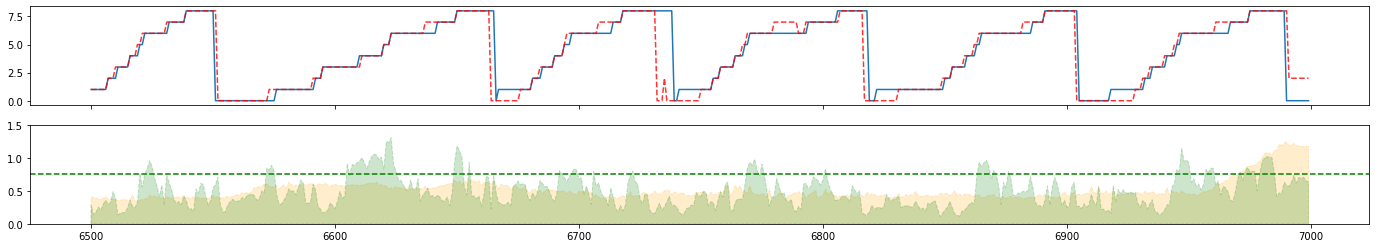

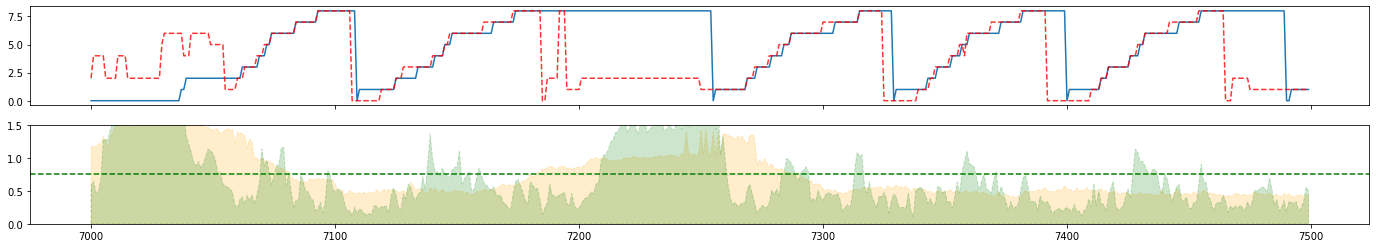

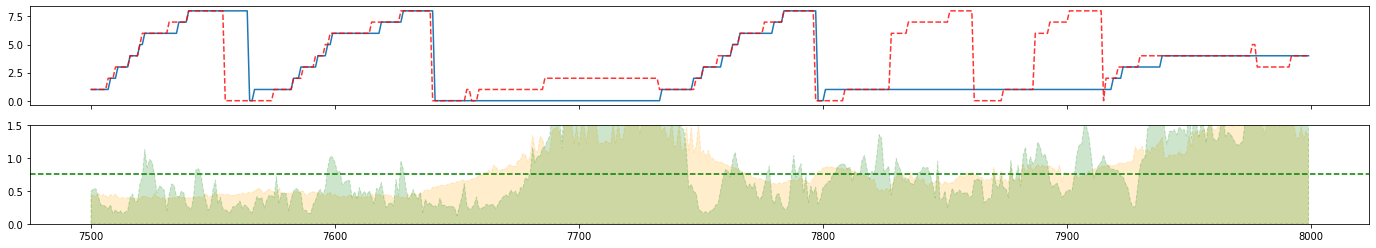

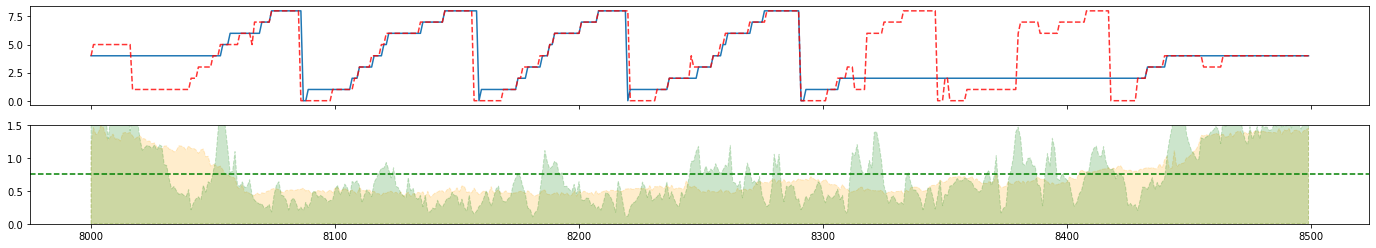

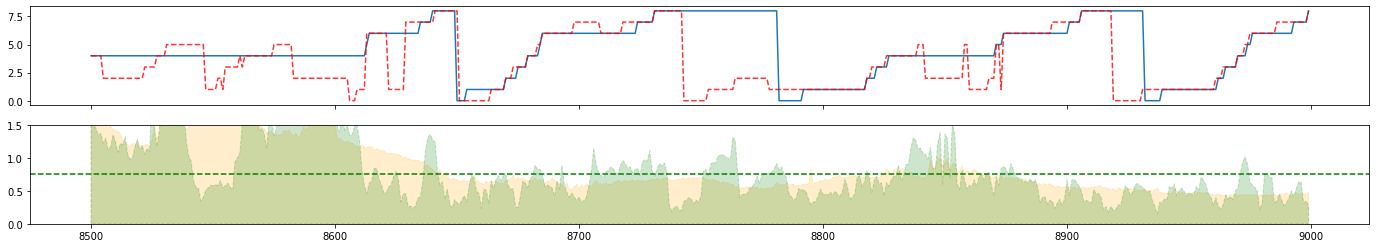

In [10]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

model = load_model("saved_model_10_01/")


START_TIME = df_data.index[0]
END_TIME = df_data.index[-1]

RULE = "200ms"

def resampling(df, rule, func):
    return df.resample(rule=rule).agg(func)

X_all_ = (read_data(DATA_PATH)
     .pipe(select_data)
     .pipe(select_df_by_range, START_TIME, END_TIME)
     .pipe(resampling, RULE, "mean")
    ).values.astype(dtype="float32")
y_all_ = (read_data(DATA_PATH)
     .pipe(select_target)
     .pipe(select_df_by_range, START_TIME, END_TIME)
     .pipe(resampling, RULE, "ffill")
#      .pipe(fillna)
     .pipe(pd.get_dummies, columns=["element_work"], drop_first=False)
    ).values.astype(dtype="int32")

print(X_all_.shape, y_all_.shape)

X_all = preprocess(X_all_, [clipping_data, scaling_data])
y_all = y_all_ #preprocess(y_all_, [astype_int32])

print(X_all.shape, y_all.shape)

draw_graph(X_all, y_all.argmax(axis=1))



from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

generator_all = TimeseriesGenerator(X_all, y_all, length=T, batch_size=4000, shuffle=False)

ys_pred = []
ys_true = []

for x, y in generator_all:
    y_pred = model.predict(x)
    ys_pred.append(y_pred)
    ys_true.append(y)

ys_prob = np.concatenate(ys_pred, axis=0).max(axis=1)
ys_pred = np.concatenate(ys_pred, axis=0).argmax(axis=1)
ys_true = np.concatenate(ys_true, axis=0).argmax(axis=1)

ys_pred.shape, ys_true.shape, ys_prob.shape

# plt.figure(figsize=(8,6))
# sns.heatmap(confusion_matrix(ys_true, ys_pred), annot=True, fmt="g");
accuracy_score(ys_true, ys_pred)

def plot_result(start=0, end=len(ys_pred)):
    cmap = plt.get_cmap("tab10") # ココがポイント
    fig, (ax1 ,ax2) = plt.subplots(2, 1, figsize=(24,4), sharex=True)
    ax1.plot(range(start,end), ys_true[start:end])
    ax1.plot(range(start,end), ys_pred[start:end], alpha=0.8, linestyle="--", color="red");
    ax2.fill_between(range(start,end), rmse[50:][start:end], alpha=0.2, linestyle="--", color="orange");
    ax2.fill_between(range(start,end), rmse2[50:][start:end], alpha=0.2, linestyle="--", color="green");
    ax2.set_ylim([0,1.5])
    ax2.axhline(y=0.75, linestyle="--", color="green")
    
    
# plot_result()

duration = 500
start, end = 0, duration
while True:
#     print(start, end)
    plot_result(start, end)
    start += duration
    end += duration
    if end>len(ys_pred):
        break

# Generative

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 9)]          0         
_________________________________________________________________
lstm_e1 (LSTM)               (None, 100)               44000     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
Total params: 54,100
Trainable params: 54,100
Non-trainable params: 0
_________________________________________________________________
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 100)          0         
____________________________

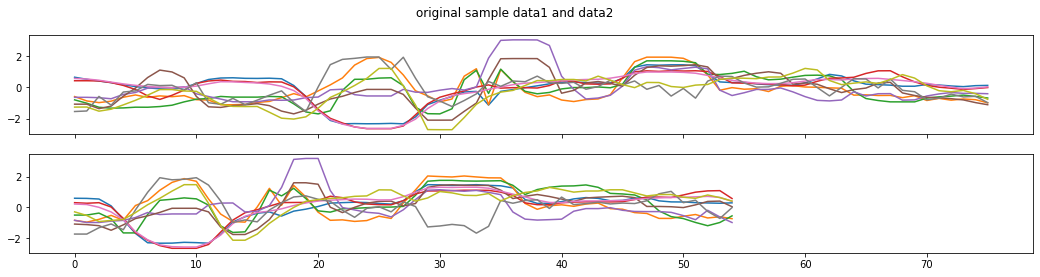

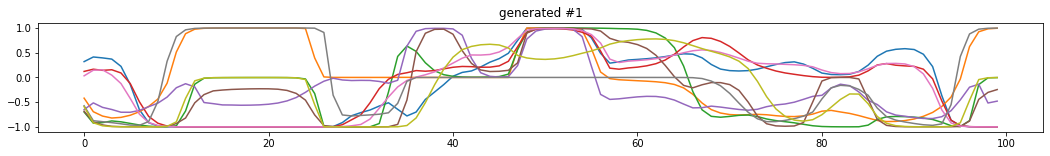

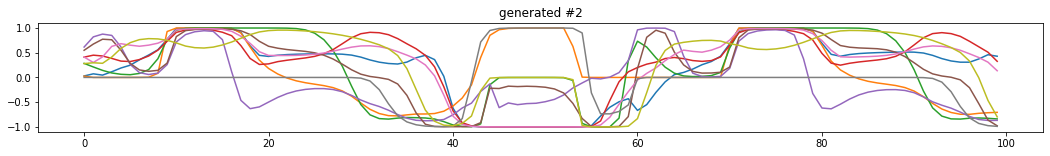

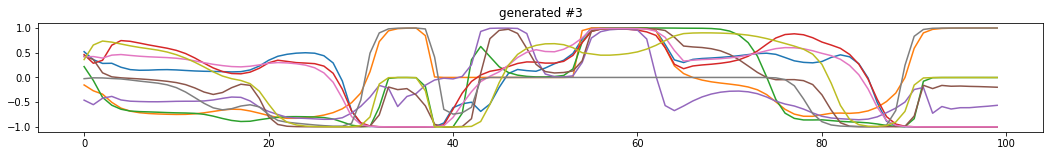

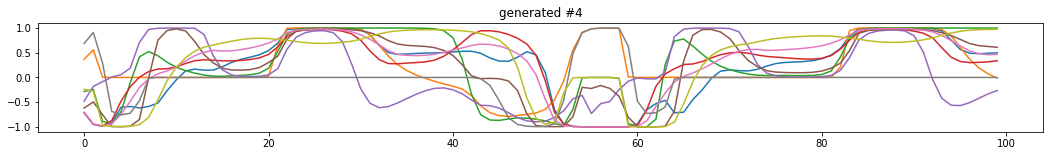

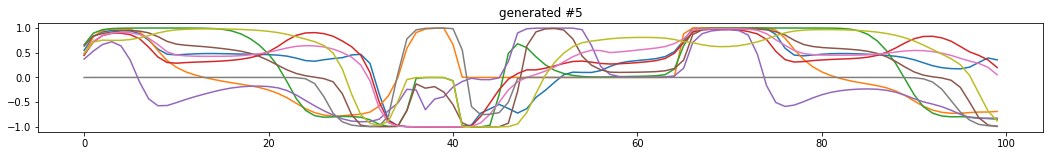

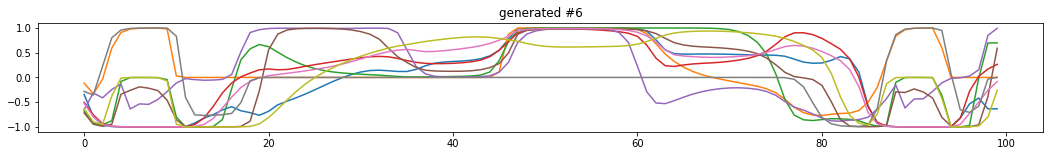

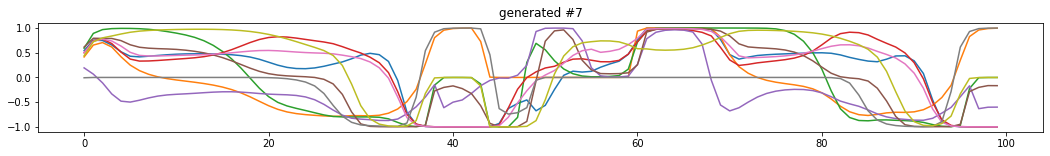

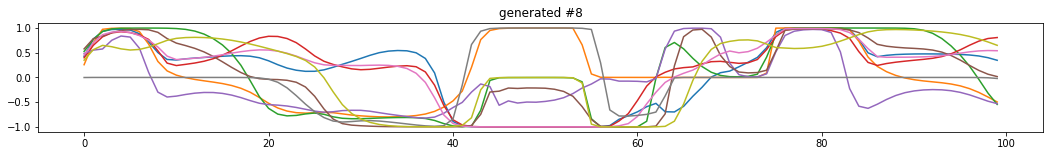

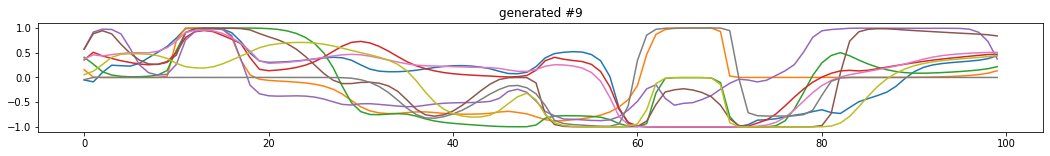

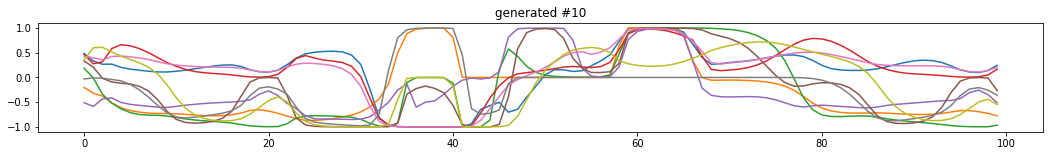

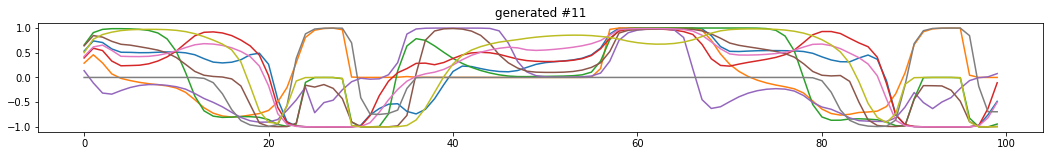

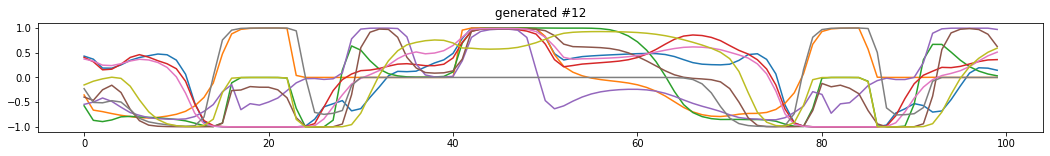

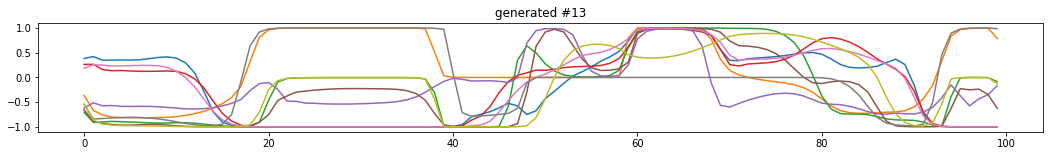

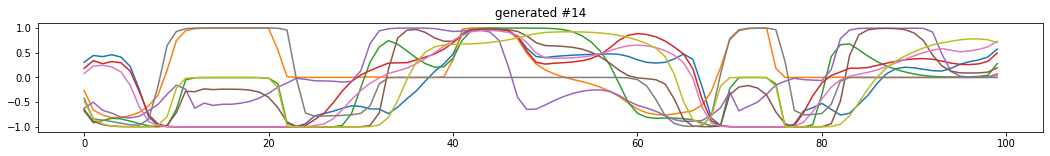

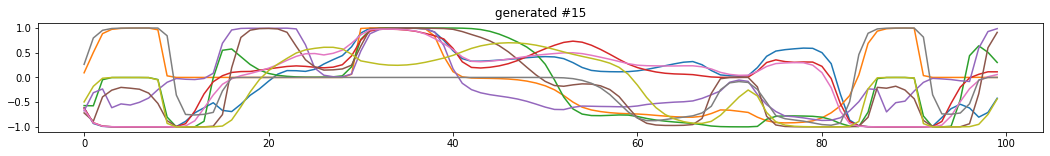

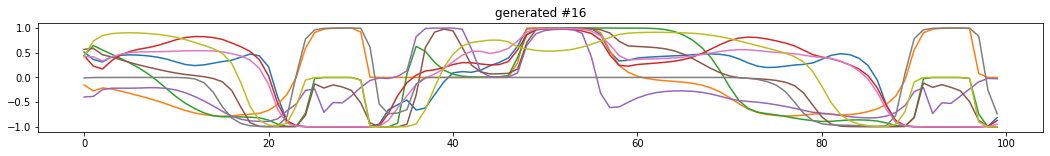

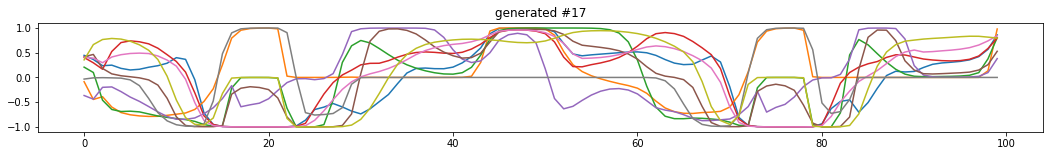

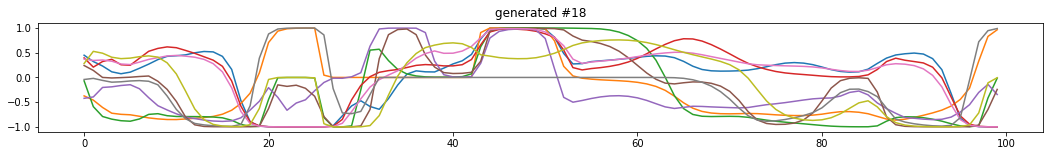

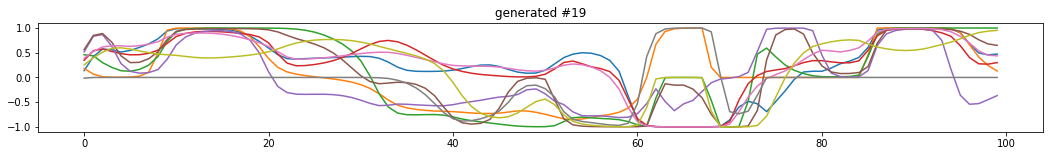

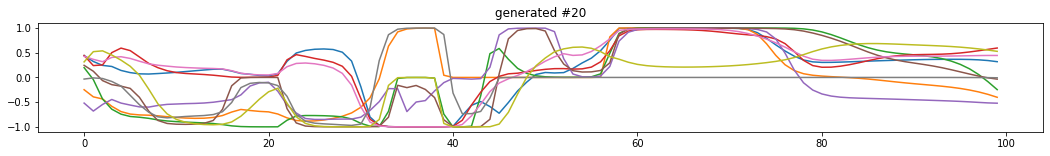

In [12]:
encoder.summary()
generator.summary()

x_gen = generator.predict(np.random.randn(1,100))
x_gen.shape

draw_graph(X_sample1, X_sample2, title="original sample data1 and data2")
for i in range(20):
    draw_graph(generator.predict(np.random.randn(1,100))[0], title=f"generated #{i+1}")
    plt.show()
    plt.close()

# Last